<img src="../tree/Fig/Logo.jpg" alt="FLAMEGPU" width="600px"/> 

# Welcome to FLAMEGPU2 Tutorial

For the purpose of this tutorial, the Jupyter notebook has been configured to work with FLAMEGPU. The Jupyter notebook is a web based environment for interactive computing.  It is capable of running code in a wide variety of programming languages. Once the instance is up and running, you can simply click on the links, and start the tutorial in the web based environment. The notebook consists of cells which can be of type code or markdown (by default, new cells are created as *code* cells). If the content is code, it will be sent to the kernel for execution and output will be displayed in the footer of the cell. If the content is markdown, it will be rendered as HTML and serves as explanatory text. You can execute the content by clicking the **_Run_** button. 


Note: You can launch the temrinal from the following link:
TODO: Update link
[FLAME GPU Tutorial Terminal for your instance](../terminals/FLAMETerminal)

or run commands using the exclamation mark. e.g. see below

In [ ]:
                        !echo "Hello World"

# Getting started with FLAMEGPU

A copy of starting code exists in your `Home` directory. Note: this is not the full FLAMEGPU2 version as all examples other than the predator prey model are omitted. The full version of FLAMEGPU can be downloaded from the [website](www.flamegpu.com).

A typical top-level directory layout is as below:


* __build:__ The location of the console and visualisation binaries for each of the examples. There is a Linux shell script for the example which will start the simulation with an initial states file (and the number of iterations to simulation in console mode)
* __iterations:__ Contains the initial state file
* __src:__ Contains main.cu, the main source file. This file includes the model definition and agent behaviours


Note: The FLAME GPU2 documentation and user guide is still under development, but can be found at [https://github.com/FLAMEGPU/FLAMEGPU2_userguide].

We are going to work with a predator-prey model. Navigate to the `ALifeTutorial` directory, create a build directory then use cmake and make to build FLAMEGPU2 and the predator-prey model. The first time this is done the compilation will take a few minutes as the whole library is built. Building individual models is much faster and will not require rebuilding the library.

In [ ]:
%cd ~/ALifeTutorial/
!mkdir -p build
%cd build
!cmake .. 
!make -j8

This will validate and process the model and build a console version of the model in release mode. FLAMEGPU can be executed as either a console application or as an interactive visualisation. Binary files are placed in `build/bin/linux-x64/<OPT>`, where `<OPT>` is either `Release` or `Debug`. 

To run the executable, call it with the following command:

In [1]:
%cd  ~/ALifeTutorial/
!./build/bin/linux-x64/Release/flamegpu2_example -i iterations/0.xml -s 1

/home/matt/ALifeTutorial
XML file 'iterations/0.xml' loaded.
Model initialised, beginning simulation...
Data saved
Simulation complete


An example output would look like below:

```
/home/matt/ALifeTutorial
XML file 'iterations/0.xml' loaded.
Model initialised, beginning simulation...
Data saved
Simulation complete

```

Examine the run script by looking at the parameters passed to the simulation. The parameters are the initial model file (-i) and the number of iterations (-s)). 

In order to modify the number of iterations, simply modify the iteration number (-s). Let's navigate to where the binary file is located and run the binary file as follows:

In [2]:
%cd  ~/ALifeTutorial/
!./build/bin/linux-x64/Release/flamegpu2_example -i iterations/0.xml -s 10

/home/matt/ALifeTutorial
XML file 'iterations/0.xml' loaded.
Model initialised, beginning simulation...
Data saved
Simulation complete


The output will be a *csv* file `iterations\PreyPred_Count.csv` which will have logged the population counts for the initial state and for the simulation step. 


When executing the binary file, you can use the following input arguments:

* `-i, --in <file.xml>` : Use <file.xml> to define the initial state
* `-s, --steps <steps>` : Run the simulation for <steps> iterations
* `-r, --random <seed>` : Use <seed> as the seed for the RandomManager
* `-v, --verbose` : Enable verbose FLAMEGPU output
* `-t, --timing` : Output timing information to stdout
* `-d, --device` : Specify the index of the GPU which should be used
    

# Exercise 01: Building FLAME GPU in notebook

In exercise one, we are going to build and execute the simulation program for the basic Predator-Prey model, followed by plotting the output results. Navigate to the `ALifeTutorial/build` directory and run `make`.

In [1]:
%cd ~/ALifeTutorial/build
!make -j8

/home/matt/ALifeTutorial/build
[  3%] Built target tinyxml2
[ 94%] Built target flamegpu2
Scanning dependencies of target flamegpu2_example
[ 96%] Building CUDA object CMakeFiles/flamegpu2_example.dir/src/main.cu.o
/home/matt/ALifeTutorial/build/_deps/thrust-src/cub/block/specializations/../../block/block_exchange.cuh(716): warning #1719-D: the initialization of member "cub::BlockExchange<InputT, BLOCK_DIM_X, ITEMS_PER_THREAD, WARP_TIME_SLICING, BLOCK_DIM_Y, BLOCK_DIM_Z, PTX_ARCH>::lane_id" will be done before that of member "cub::BlockExchange<InputT, BLOCK_DIM_X, ITEMS_PER_THREAD, WARP_TIME_SLICING, BLOCK_DIM_Y, BLOCK_DIM_Z, PTX_ARCH>::warp_id"

/home/matt/ALifeTutorial/build/_deps/thrust-src/cub/device/dispatch/../../agent/agent_histogram.cuh(709): warning #1719-D: the initialization of member "cub::AgentHistogram<AgentHistogramPolicyT, PRIVATIZED_SMEM_BINS, NUM_CHANNELS, NUM_ACTIVE_CHANNELS, SampleIteratorT, CounterT, PrivatizedDecodeOpT, OutputDecodeOpT, OffsetT, PTX_ARCH>::output

## Running the model

Now, run the simulation for 100 iterations:

In [14]:
%cd  ~/ALifeTutorial/
!./build/bin/linux-x64/Release/flamegpu2_example -i iterations/0.xml -s 100

/home/matt/ALifeTutorial
XML file 'iterations/0.xml' loaded.
Model initialised, beginning simulation...
Data saved
Simulation complete


## Generate and view the graph

The generated *csv* file contains the number of prey and predator agents per iteration. Navigate to the `iterations` folder and plot the result:

/home/matt/ALifeTutorial/iterations


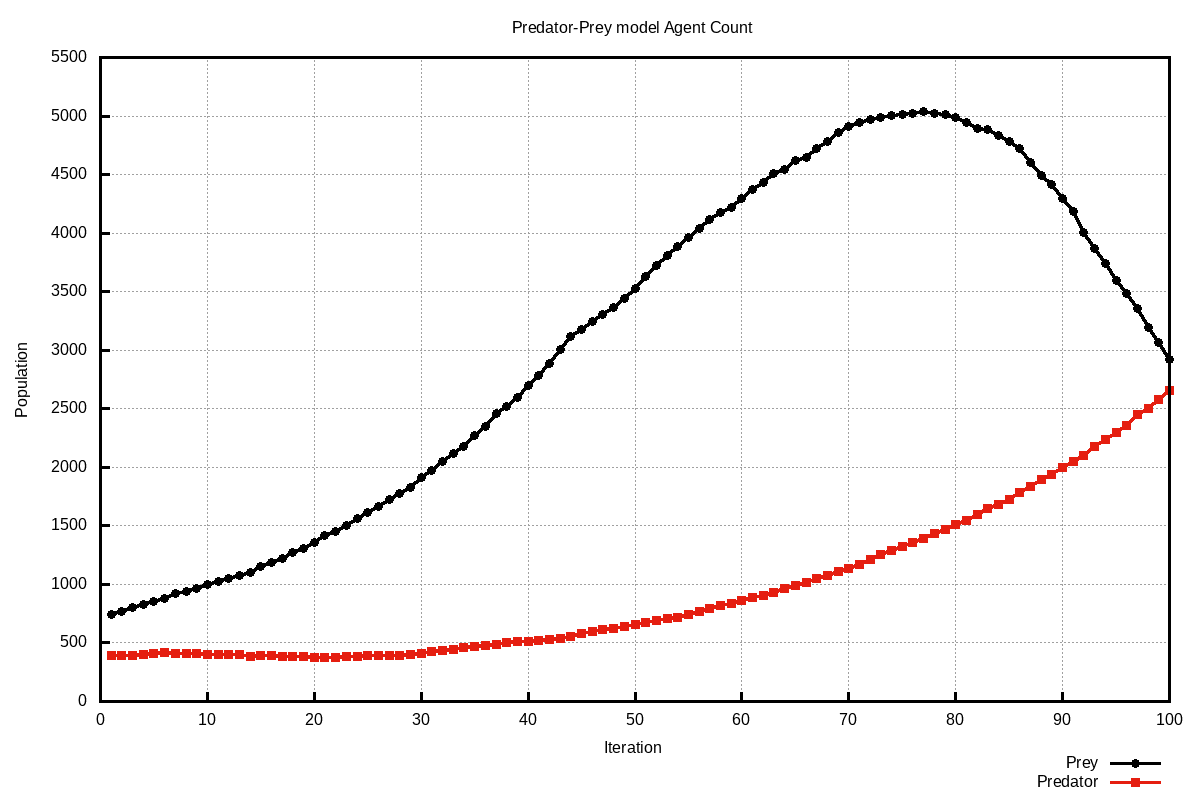

In [15]:
%cd ~/ALifeTutorial/iterations
!gnuplot make_plot_PreyPred.gp 2&>/dev/null
from IPython.display import Image
Image("PreyPredator.png")

   # Exercise 02: Changing Predator-Prey model's behaviour

Now, let's change the parameters in the initial data and see how it affects the behaviour. To generate a new randomised set of initial data `0.xml`, navigate to the iterations folder and use the python script 'xmlGen.py'. 

1. Compile and re-run the executable with different parameters:


In [13]:
%cd ~/ALifeTutorial/iterations
!python3 xmlGen.py 800 400 0.03 0.05 50

/home/matt/ALifeTutorial/iterations
XML file generated successfully!



where 800 is the number of prey, 400 is the number of predators, 0.03 and 0.05 are the reproduction rates for the prey/predators respectively, and 50 is the energy a predator gains when eating a prey. 

2. Re-run the executable again for 300 iterations and plot the results. You can observe the predator prey behaviour where both species become extinct after certain number of iterations.

In [ ]:
%cd  ~/ALifeTutorial/
!./build/bin/linux-x64/Release/flamegpu2_example -i iterations/0.xml -s 300

Navigate to the `iterations` folder and plot the result: 

In [ ]:
%cd ~/ALifeTutorial/iterations
!gnuplot make_plot_PreyPred.gp 2&>/dev/null
from IPython.display import Image
Image("PreyPredator.png")

3. Change other parameters or the iteration number to see how the behaviour changes over time. Try to modify the simulation parameters to produce oscillating population dynamics.

   # Exercise 03: Extending the Predator-Prey model (Optional)
In this exercise, we are going to extend our model to include grass to familiarise you with how agents and their behaviours are implemented within FLAMEGPU2. The grass will provide a source of food for the prey which should behave according to the following rules:


* A prey’s energy is reduced by 1 unit each time it moves.
* A prey’s energy increases each time it eats grass.
* A prey dies if it has run out of energy.
* Once eaten, grass regrows after a fixed number of iterations.


With respect to the implementation this will require , a fourth and fifth message type as grass should only be eaten by prey within a certain certain radius. The mechanism for "grazing" is as follows:


1.  Grass agents which currently are currently available read the positions of the prey from the location messages to locate the nearest prey. 
2. If a prey was in eating range, a `grass_eaten_message` message is output. Note that if there is more than 1 prey on within the minimum distance, the grass agent should be eaten by the closest prey.
3.  Grass agents then modify the `active` agent variable to indicate they are in a regrowth period and cannot be eaten at this time.
4.  Prey agents read the `grass_eaten_message` messages and check to see if any match their ID. They then increase their energy accordingly.
5. Prey agents die if they do not have enough life/energy.



The figure below shows a dependency graph for the Predator-Prey model with grass: 

<img src="../tree/Fig/prey_pred_grass.jpg" alt="Flow diagram for Predator-Prey model with grass" width="600px"/> 


For simplicity a Grass agent description and corresponding function descriptions matching the behaviour described above have already been added to `src/main.cu`. In this exercise, you need to modify the `main.cu` file to add the following behaviour to the functions stubs described below (See [Last Section](#Editing-Files) on how to edit source files):

* 3.1 *__grass_output_location__*: each grass agent outputs a `grass_location` message to provide information. In a more advanced model prey agent can use this information to migrate to areas of high food concentration.
* 3.2 *__grass_eaten__*: each grass agent should iterate over `prey_location_messages` and checks the distance between its location and the prey agent. If the grass is available and the distances less than `GRASS_EAT_DISTANCE`, then the grass is eaten by the closet prey and the regrowth cycle starts. Note that if there are multiple preys within the `GRASS_EAT_DISTANCE`, then the closet prey to the grass, eats it and outputs a message `grass_eaten` containing the ID of the prey who ate it. This behaviour is very similar to prey checking if they are eaten by predators, you may wish to look at the `prey_eaten` function for inspiration. Once the grass is eaten, it should no longer be available until the `death_cycles` reaches `GRASS_REGROW_CYCLES`. 
* 3.3 *__prey_eat_or_starve__*: each prey agent iterates over `grass_eaten_messages` and checks the ID against it ID. If the grass eaten message indicates that this prey ate some grass then increase the prey's life by adding energy. If it's life is less than 1, the prey should die. This behaviour is similar to the `pred_eat_or_starve` function.
* 3.4 *__grass_growth__*: If the the `death_cycles` variable is equal to `GRASS_REGROW_CYCLES`, then the grass agent becomes available and the `death_cycles` should restart. If the grass is not available (meaning the `death_cycles` variable is not equal to `GRASS_REGROW_CYCLES`), then the `death_cycles` variable should be incremented.

In the case where grass is included, prey agents require an energy (`life`) variable similar to predators. This variable is randomly selected from the interval of [0,50]. Once grass is eaten, the `available` variable is set to 0 and it takes up to `GRASS_REGROW_CYCLES` iterations till the grass re-grow. 

Now, generate a new initial data file using below parameters:

In [27]:
%cd ~/ALifeTutorial/iterations
!python3 xmlGenWithGrass.py 800 400 2000 0.05 0.03 50

/home/matt/ALifeTutorial/iterations
XML file generated successfully!


where 800 is the number of preys, 400 is the number of predators, 2000 is the number of grass, 0.05 and 0.03 are the reproduction rates for both prey and predator, 75 is the prey's energy gain, and 50 is the predator's energy gain. 


Re-build the model via `make`:

In [24]:
%cd ~/ALifeTutorial/build
!make -j8

/home/matt/ALifeTutorial/build
[  3%] Built target tinyxml2
[ 94%] Built target flamegpu2
Scanning dependencies of target flamegpu2_example
[ 96%] Building CUDA object CMakeFiles/flamegpu2_example.dir/src/main.cu.o
/home/matt/ALifeTutorial/build/_deps/thrust-src/cub/block/specializations/../../block/block_exchange.cuh(716): warning #1719-D: the initialization of member "cub::BlockExchange<InputT, BLOCK_DIM_X, ITEMS_PER_THREAD, WARP_TIME_SLICING, BLOCK_DIM_Y, BLOCK_DIM_Z, PTX_ARCH>::lane_id" will be done before that of member "cub::BlockExchange<InputT, BLOCK_DIM_X, ITEMS_PER_THREAD, WARP_TIME_SLICING, BLOCK_DIM_Y, BLOCK_DIM_Z, PTX_ARCH>::warp_id"

/home/matt/ALifeTutorial/build/_deps/thrust-src/cub/device/dispatch/../../agent/agent_histogram.cuh(709): warning #1719-D: the initialization of member "cub::AgentHistogram<AgentHistogramPolicyT, PRIVATIZED_SMEM_BINS, NUM_CHANNELS, NUM_ACTIVE_CHANNELS, SampleIteratorT, CounterT, PrivatizedDecodeOpT, OutputDecodeOpT, OffsetT, PTX_ARCH>::output

Now, run the simulation for 600 iterations:

In [ ]:
%cd  ~/ALifeTutorial/
!./build/bin/linux-x64/Release/flamegpu2_example -i iterations/0.xml -s 600

/home/matt/ALifeTutorial
XML file 'iterations/0.xml' loaded.
Model initialised, beginning simulation...
Data saved
Simulation complete


Now, plot your results by running below cell. Your plot should be similar to below figure:

<img src="../tree/Fig/prey_predator_grass.jpg" alt="Examples of predator-prey model simulation with grass included" width="600px"/> 

/home/matt/ALifeTutorial/iterations


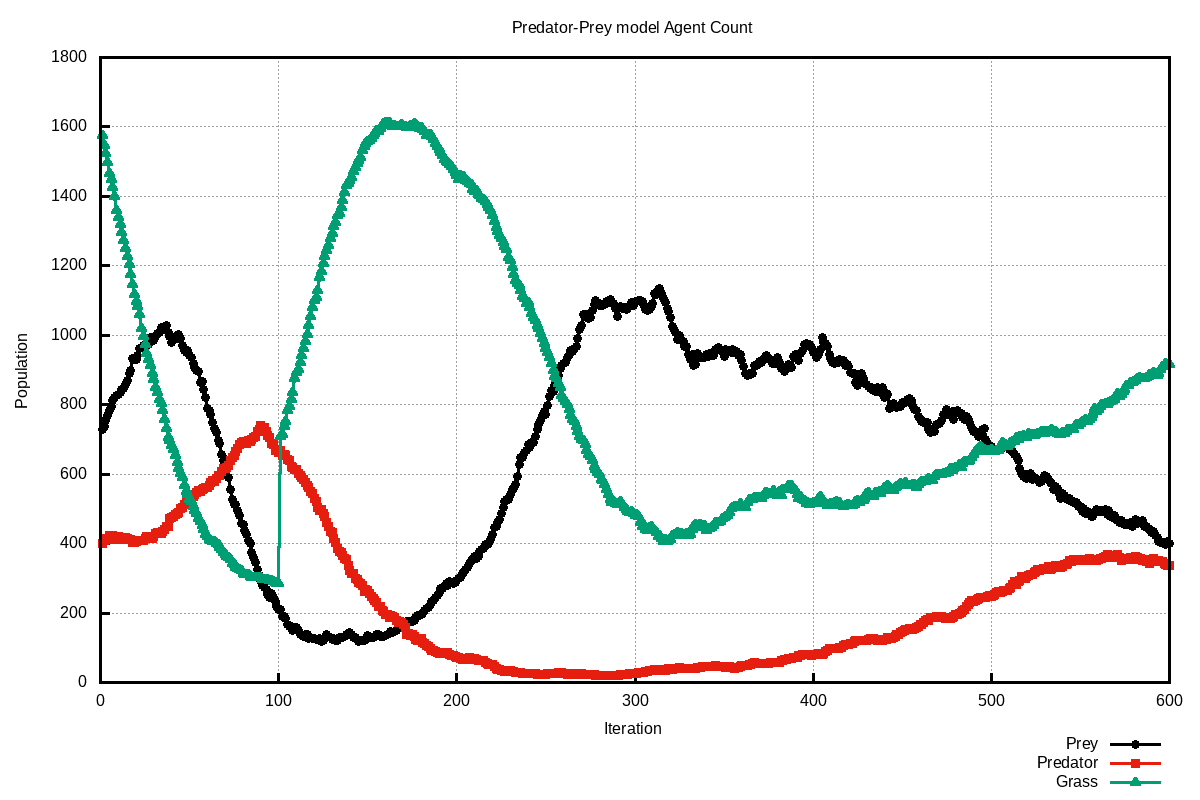

In [26]:
%cd ~/ALifeTutorial/iterations
!gnuplot make_plot_PreyPred_IncGrass.gp 2&>/dev/null
from IPython.display import Image
Image("PreyPredator.png")

## Experimenting with the Model
Try changing the parameters to see how this will change the behaviour of the agents causing the behaviours to change. If you have completed all the above exercises then try modifying the model file and functions file to allow prey agents to migrate to areas of high concentrations of food. You can implement this by adding an additional velocity term to the preys steering velocity and by allowing the prey agents to query the `grass_location` messages.

For more information on FLAMEGPU see the [FLAMEGPU website](www.flamegpu.com) and the documentation which gives detailed instructions on all aspects of FLAMEGPU modelling. More examples can be found on [FLAMEGPU GitHub repository](https://github.com/FLAMEGPU/FLAMEGPU.git).

You can download the solutions from GitHub by checking out the `Exercise_3_solution` branch. E.g. 

In [ ]:
!git clone https://github.com/MILeach/ALifeTutorial -b Exercise_3_solution

# Editing Files

You can use Jupyter to edit model files. Use this link to explore the [turorial directory](../tree) or use below links to open the model file, functions file or initial model data directory for editing:

* [main.cu](../edit/src/main.cu)
* [0.xml](../edit/~/ALifeTutorial/iterations/0.xml)

Note: You are given 3, 2-hour sessions for this tutorial. Save and download your modifed files before the end of each session.
